<a href="https://colab.research.google.com/github/suhkisoo/course-v3/blob/master/Final_Homework_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"
#Because this code is based on old vesion, so You need to download old version of torch and torchvision.

     |████████████████████████████████| 753.4MB 16kB/s 
     |████████████████████████████████| 4.0MB 57.2MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


## Pretrained GAN

In [ ]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
#import everything from fastai.vision, fastai.callbacks, and fastai.vision.gan

In [ ]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'
#download 7390 datas from https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet and make path_hr and path_lr. 'images' are pre-existing folder.  

## Crappified data

Prepare the input data by crappifying images.

In [ ]:
from crappify import *
#because it is not working we need to define this function. 

ModuleNotFoundError: ignored

In [ ]:
from PIL import Image, ImageDraw, ImageFont
#import Image, ImageDraw, ImageFont from PIL

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)
#Define crappifier by using resize function. In addition, add numbers by using ImageDraw. Numbers are randomly added by random.randint

Uncomment the first time you run this notebook.

In [ ]:
il = ImageList.from_folder(path_hr)
#Make imagelist il by using path_hr folder 7390 datas. 
parallel(crappifier(path_lr, path_hr), il.items)
#Use crappifier function to il to make crappified images in path_lr.

For gradual resizing we can change the commented line here.

In [ ]:
bs,size=32, 128
#bs,size = 24,160
#bs,size = 8,256
#Set batchsize and image size. You can change it for the faster learning 
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [ ]:
arch = models.resnet34
#Use model resnet34 and define it as arch. 
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
#Define src as randomly seted imagelist. And it is splited by 1:9.

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data
#Define get_data function. get_data function change src to databunch. It zooms image and normalize data to make learning easy. 
#In addition, it label low resolution image with high resolution image. 

In [ ]:
data_gen = get_data(bs,size)
#Make data_gan by using get_data function. 

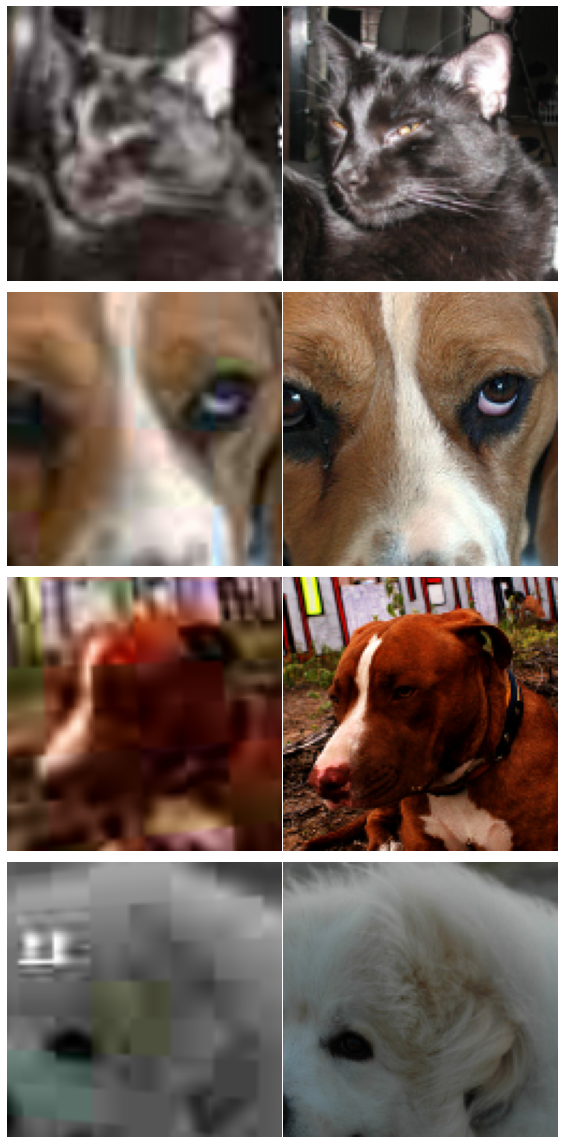

In [ ]:
data_gen.show_batch(4)
#show 4 rows of images of data bunch. It shows 4 high resolution images and 4 low resolution images. 

In [ ]:
wd = 1e-3
#Define weight decay

In [ ]:
y_range = (-3.,3.)
#Set y_range (-3., 3.)

In [ ]:
loss_gen = MSELossFlat()
#Use mean square error function as loss of generator

In [ ]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)
#Define create_gen_learner by using unet_learner with wd as 1e-3, y range as (-3., 3.), and loss function as MSELossFlat(). 
#It use data_gen and arch definded before. 

In [ ]:
learn_gen = create_gen_learner()
#Make learn_gen by using create_gen_learner() function.

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8)
#learn with generatort 2 ctycles. And pct_start=0.8 means learning rate increase until 0.8 point of datas and decrease from 0.8 point of datas. 

epoch,train_loss,valid_loss,time
0,0.078767,0.056703,01:47
1,0.053708,0.048832,01:42


In [ ]:
learn_gen.unfreeze()
#Unfreeze  leran_gen to retrain it. 

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))
#Train generator 3times by using slice. Slice means learning rate start with 1e-6 and end with 1e-3.

epoch,train_loss,valid_loss,time
0,0.051860,0.048914,01:44
1,0.050434,0.046026,01:44
2,0.047918,0.044346,01:42


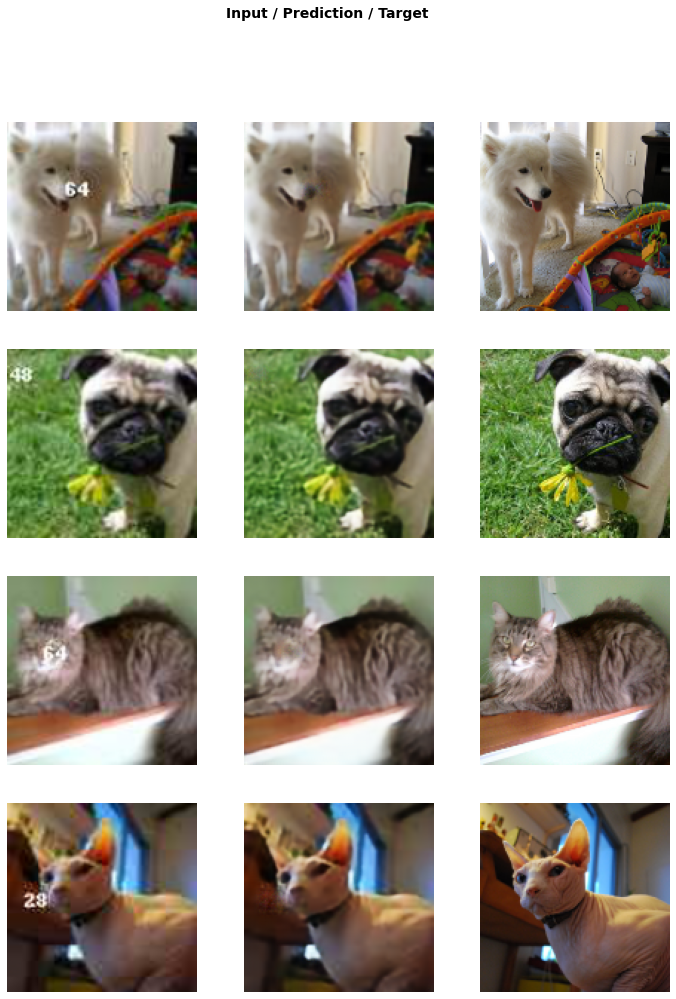

In [ ]:
learn_gen.show_results(rows=4)
#Show 4 results of learn_gen after two kinds of training. You can see Input, Prediction and target. 

In [ ]:
learn_gen.save('gen-pre2')
#Save learn_gen as 'gen-pre2'.

## Save generated images

In [ ]:
learn_gen.load('gen-pre2');
#Load 'gen-pre2' to use it again.  

In [ ]:
name_gen = 'image_gen'
#Define name_gen as 'image_gen'
path_gen = path/name_gen
#Define path_gen as 'path/name_gen'. Here path is '/root/.fastai/data/oxford-iiit-pet'

In [ ]:
# shutil.rmtree(path_gen)

In [ ]:
path_gen.mkdir(exist_ok=True)
#Make a new directory at path_gen

In [ ]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1
#Define save_preds. And save_preds save predictions of learn_gen. 

In [ ]:
save_preds(data_gen.fix_dl)
#Use save_preds by using data_gen.

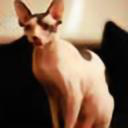

In [ ]:
PIL.Image.open(path_gen.ls()[0])
#Open one of the images in path_gen. This image is generated by save_preds function. 

## Train critic

In [ ]:
learn_gen=None
gc.collect()
#Collect garbage collection to better memory use.

22

Pretrain the critic on crappy vs not crappy.

In [ ]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data
#Define get_crit_data function. 
#src is defined by using path datas. And it is splited by 0.1.
#Define ll by labeling src with classes.
#Data is formed with ll.

In [ ]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)
#Make data_crit by using ger_crit_data function, bs and size. In addition, bs and size are defined before. 

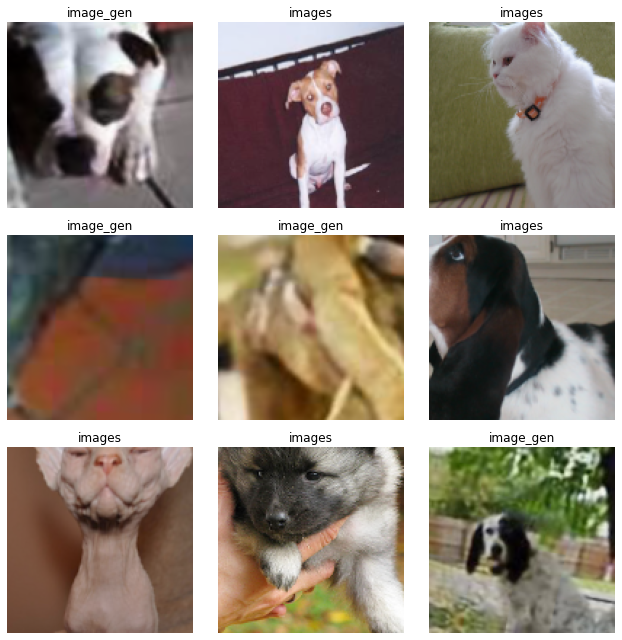

In [ ]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)
#Show data_crit's images in 3 rows. image_gen is what is made by generator. 

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())
#Define loss of critic by AdaptiveLoss. 

In [ ]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)
#Define create_critic_learner bt usinf loss_critic and gan_critic(). 

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)
#leanr critic with creat_critic_learner function. 

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3)
#Train learn_critic with 6 cycles by usinf learning rate 1e-3.

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.690536,0.686014,0.551054,02:03
1,0.479121,0.450438,0.776581,02:01
2,0.162788,0.362873,0.843533,02:01
3,0.096965,0.154171,0.938946,02:06
4,0.060471,0.145079,0.943704,02:04
5,0.055494,0.079519,0.974074,02:03


In [ ]:
learn_critic.save('critic-pre2')
#Save learn_critic as 'critic-pre2'

## GAN

Now we'll combine those pretrained model in a GAN.

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()
#One more time collect garbage collection to better memory use.

19476

In [ ]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)
#Create data_crit by using get_crit_data function.

In [ ]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')
#Create learn_crit by using create_critic_learner and load 'critic_pre2' to use it.

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2')
#Create learn_gen by using create_gen_learner() and load 'gen-pre2'.

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
#Define switcher as switcher that goes back to generator/critic when the loss goes below `gen_thresh`/`crit_thresh`.
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
#Define learn with GANlearner.from_learners. You use learn_gen, learn_crit, and switcher to make it. 
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
#Callback that handles multiplying the learning rate by mult_lr for the critic.

In [ ]:
lr = 1e-4
#Set learning rate as 1e-4.

In [ ]:
learn.fit(40,lr)
#Learn 40times. 

epoch,train_loss,gen_loss,disc_loss
1,2.071352,2.025429,4.047686
2,1.996251,1.850199,3.652173
3,2.001999,2.035176,3.612669
4,1.921844,1.931835,3.600355
5,1.987216,1.961323,3.606629
6,2.022372,2.102732,3.609494
7,1.900056,2.059208,3.581742
8,1.942305,1.965547,3.538015
9,1.954079,2.006257,3.593008
10,1.984677,1.771790,3.617556


In [ ]:
learn.save('gan-1c')
#Save learn as 'gan-1c'

In [ ]:
learn.data=get_data(16,192)
#Get data with 16 batch size and 192 image size.

In [ ]:
learn.fit(10,lr/2)
#learn 10 times with half learning rate. 

epoch,train_loss,gen_loss,disc_loss
1,2.578580,2.415008,4.716179
2,2.620808,2.487282,4.729377
3,2.596190,2.579693,4.796489
4,2.701113,2.522197,4.821410
5,2.545030,2.401921,4.710739
6,2.638539,2.548171,4.776103
7,2.551988,2.513859,4.644952
8,2.629724,2.490307,4.701890
9,2.552170,2.487726,4.728183
10,2.597136,2.478334,4.649708


In [ ]:
learn.show_results(rows=16)
#Show 16 results of learning. 

NameError: ignored

In [ ]:
learn.save('gan-1c')
#Save it as 'gan-1c'

## fin